# CAPSTONE PROJECT
# Title: IN VEHICLE COUPON RECOMMENDATION SYSTEM

### GROUP TWARB

### MEMBERS: 
1. Austin Kanja
2. Benson Ouma
3. Rahab Gachie
4. Ted Ronoh 
5. Winnie Odoyo


## Business Understanding

In today's competitive marketing landscape, organizations must maximize how and when they provide promotional bargains (coupons) to potential customers. This project's goal is to create a recommendation system that predicts whether a person will utilize a particular type of coupon based on their demographics, current context (e.g., weather, time), and previous behavior. 

## Problem Statement
In the competitive food and beverage industry, businesses frequently use coupons to attract customers. However, sending irrelevant or poorly timed coupons often results in low redemption rates, wasted marketing resources, and customer disengagement. At the same time, customers value offers that are timely, relevant, and tailored to their preferences and current situation. Currently, businesses lack a data-driven system to determine which specific coupon type and expiration period should be offered to maximize the likelihood of acceptance.

Objective:
To develop a predictive model that leverages passenger demographics, trip context (time, weather, destination, etc.), and behavioral patterns to recommend the most appropriate coupon type and expiration period for a given passenger during their journey. The model aims to identify which coupon-expiration combination is most likely to be accepted, improving both customer satisfaction and campaign efficiency.

## Data Understanding
The data set has been sourced from UC Irvine Machine Learning Repository https://archive.ics.uci.edu/datasets/
The dataset contains 12,684 records and 26 features, including:
- Demographic information: gender, age, marital Status, education, income
- Contextual data: weather, temperature, time, destination, passanger
- Behavioral indicators: frequency of visiting Bar, Coffee-house, Restaurant Less Than 20, etc.
- Target variable(Y): Coupon and expiration

### Loading the Data
Importing the libraries that will be used through out the project.


In [39]:
import pandas as pd   
import numpy as np  
import zipfile
import matplotlib.pyplot as plt 
import seaborn as sns 

In [40]:
# extract the files
zip_path = 'in+vehicle+coupon+recommendation.zip'

extract_dir = 'unzipped/'

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    
    zip_ref.extractall(extract_dir)
    print(f"Files extracted to {extract_dir}")
    
    print("Files in the zip archive:")
    for file in zip_ref.namelist():
        print(file)

Files extracted to unzipped/
Files in the zip archive:
in-vehicle-coupon-recommendation.csv


In [41]:
# Load the dataset
df = pd.read_csv('unzipped\in-vehicle-coupon-recommendation.csv')
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12684 entries, 0 to 12683
Data columns (total 26 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   destination           12684 non-null  object
 1   passanger             12684 non-null  object
 2   weather               12684 non-null  object
 3   temperature           12684 non-null  int64 
 4   time                  12684 non-null  object
 5   coupon                12684 non-null  object
 6   expiration            12684 non-null  object
 7   gender                12684 non-null  object
 8   age                   12684 non-null  object
 9   maritalStatus         12684 non-null  object
 10  has_children          12684 non-null  int64 
 11  education             12684 non-null  object
 12  occupation            12684 non-null  object
 13  income                12684 non-null  object
 14  car                   108 non-null    object
 15  Bar                   12577 non-null

,destination,passanger,weather,temperature,time,coupon,expiration,gender,age,maritalStatus,...,CoffeeHouse,CarryAway,RestaurantLessThan20,Restaurant20To50,toCoupon_GEQ5min,toCoupon_GEQ15min,toCoupon_GEQ25min,direction_same,direction_opp,Y
0,No Urgent Place,Alone,Sunny,55,2PM,Restaurant(<20),1d,Female,21,Unmarried partner,...,never,NaN,4~8,1~3,1,0,0,0,1,1
1,No Urgent Place,Friend(s),Sunny,80,10AM,Coffee House,2h,Female,21,Unmarried partner,...,never,NaN,4~8,1~3,1,0,0,0,1,0
2,No Urgent Place,Friend(s),Sunny,80,10AM,Carry out & Take away,2h,Female,21,Unmarried partner,...,never,NaN,4~8,1~3,1,1,0,0,1,1
3,No Urgent Place,Friend(s),Sunny,80,2PM,Coffee House,2h,Female,21,Unmarried partner,...,never,NaN,4~8,1~3,1,1,0,0,1,0
4,No Urgent Place,Friend(s),Sunny,80,2PM,Coffee House,1d,Female,21,Unmarried partner,...,never,NaN,4~8,1~3,1,1,0,0,1,0


### 1. Data Cleaning

#### 1.0 Check for missing values

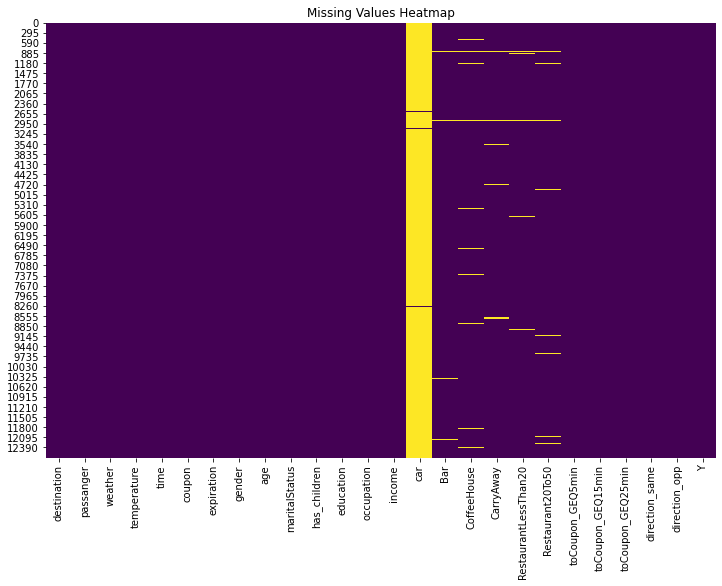

In [42]:
# check for missing values
df.isnull().sum()

# visualize the missing values
plt.figure(figsize=(12, 8))
sns.heatmap(df.isnull(), cbar=False, cmap='viridis')
plt.title('Missing Values Heatmap')
plt.show()

From the above visualization, the car column has excessive missing values (99%). The ideal way of handling this is by dropping the column.


#### 1.1 Handling Missing Values

In [43]:
# drop car column
df_cleaned = df.drop(columns=['car'])

# For categorical columns with few missing values we fill with mode
cat_cols = df_cleaned.select_dtypes(include=['object']).columns
for col in cat_cols:
    if df_cleaned[col].isnull().sum() > 0:
        df_cleaned[col] = df_cleaned[col].fillna(df_cleaned[col].mode()[0])

# For numerical columns we fill with median
num_cols = df_cleaned.select_dtypes(include=['int64', 'float64']).columns
for col in num_cols:
    if df_cleaned[col].isnull().sum() > 0:
        df_cleaned[col] = df_cleaned[col].fillna(df_cleaned[col].median())

# Check if any missing values remain
print(df_cleaned.isnull().sum().sum())

0


In [44]:
print(num_cols)
print(cat_cols)

Index(['temperature', 'has_children', 'toCoupon_GEQ5min', 'toCoupon_GEQ15min',
       'toCoupon_GEQ25min', 'direction_same', 'direction_opp', 'Y'],
      dtype='object')
Index(['destination', 'passanger', 'weather', 'time', 'coupon', 'expiration',
       'gender', 'age', 'maritalStatus', 'education', 'occupation', 'income',
       'Bar', 'CoffeeHouse', 'CarryAway', 'RestaurantLessThan20',
       'Restaurant20To50'],
      dtype='object')


#### 1.2 Check for duplicate rows

In [45]:
# Checking for duplicated rows
print(f"Number of duplicate rows: {df_cleaned.duplicated().sum()}")

Number of duplicate rows: 74


In [46]:
# remove the duplicate rows
initial_rows = len(df_cleaned)
df_cleaned = df_cleaned.drop_duplicates()
duplicates_removed = initial_rows - len(df_cleaned)
print(f"✓ Removed {duplicates_removed} duplicate rows")


✓ Removed 74 duplicate rows


Correct the typo in 'passanger' to 'passenger'

In [47]:
df_cleaned = df_cleaned.rename(columns={'passanger': 'passenger'})
print("✓ Fixed column name: 'passanger' → 'passenger'")

✓ Fixed column name: 'passanger' → 'passenger'


In [48]:

# Standardize age column (convert to consistent format)
print("\
Standardizing age column:")
print("-" * 25)
print("Original age values:", df_cleaned['age'].unique())

# Create age mapping
age_mapping = {
    'below21': '18-20',
    '21': '21-25', 
    '26': '26-30',
    '31': '31-35',
    '36': '36-40',
    '41': '41-45',
    '46': '46-50',
    '50plus': '50+'
}

df_cleaned['age_group'] = df_cleaned['age'].map(age_mapping)
print("New age groups:", df_cleaned['age_group'].unique())
print("✓ Created standardized age_group column")

print(f"\
Current dataset shape: {df_cleaned.shape}")
print(f"Remaining missing values: {df_cleaned.isnull().sum().sum()}")

Standardizing age column:
-------------------------
Original age values: ['21' '46' '26' '31' '41' '50plus' '36' 'below21']


New age groups: ['21-25' '46-50' '26-30' '31-35' '41-45' '50+' '36-40' '18-20']
✓ Created standardized age_group column
Current dataset shape: (12610, 26)
Remaining missing values: 0


#### 1.3 Checking for outliers in the columns

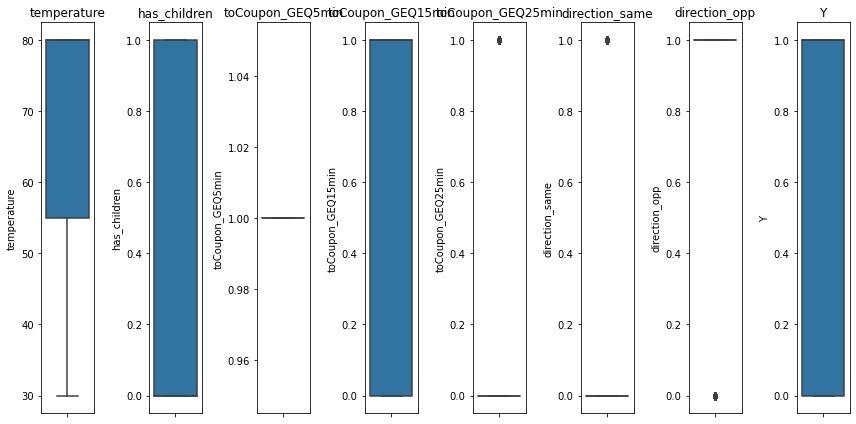

Outliers in temperature: 0
Outliers in has_children: 0
Outliers in toCoupon_GEQ5min: 0
Outliers in toCoupon_GEQ15min: 0
Outliers in toCoupon_GEQ25min: 1463
Outliers in direction_same: 2718
Outliers in direction_opp: 2718
Outliers in Y: 0


In [49]:

# Boxplots for numerical variables
plt.figure(figsize=(12, 6))
for i, col in enumerate(num_cols, 1):
    plt.subplot(1, len(num_cols), i)
    sns.boxplot(y=df_cleaned[col])
    plt.title(col)
plt.tight_layout()
plt.show()

# Statistical outlier detection
for col in num_cols:
    q1 = df_cleaned[col].quantile(0.25)
    q3 = df_cleaned[col].quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    
    outliers = df_cleaned[(df_cleaned[col] < lower_bound) | (df_cleaned[col] > upper_bound)]
    print(f"Outliers in {col}: {len(outliers)}")

#### 1.4 Checking for unusual categories in categorical variables
Checking for unusual categories ensures:
* Data quality- to catch typos or inconsistent labels.
* Model readiness- find rare categories that could hurt performance.
* Better features- decide if rare categories should be grouped or dropped.
* Understand distribution- see if the feature is balanced or dominated by one class.

In [53]:
# Check for unusual/rare categories in categorical variables
for col in cat_cols:
    value_counts = df_cleaned[col].value_counts(normalize=True)
    
    print(f"\nValue counts for {col}:")
    print(value_counts)
    
    # Identify rare categories (<1% of data)
    rare_categories = value_counts[value_counts < 0.01].index
    
    if len(rare_categories) > 0:
        print(f"Rare categories in {col}: {list(rare_categories)}")



Value counts for destination:
No Urgent Place    0.496907
Home               0.256146
Work               0.246947
Name: destination, dtype: float64


KeyError: 'passanger'

#### 1.5 Examining unique values for the categorical columns
The purpose of this is to  understand the possible categories each variable can take, detect unexpected or inconsistent entries and identify rare or dominant categories.

In [ ]:
# Examine unique values in categorical columns
categorical_cols = ['destination', 'passanger', 'weather', 'time', 'coupon', 'expiration', 
                   'gender', 'age', 'maritalStatus', 'has_children', 'education', 'occupation', 
                   'income', 'car']

print("Unique values in categorical columns:")
for col in categorical_cols:
    if col in df_cleaned.columns:
        unique_vals = df_cleaned[col].unique()
        print(f"\
{col} ({len(unique_vals)} unique values):")
        print(unique_vals)

Unique values in categorical columns:
destination (3 unique values):
['No Urgent Place' 'Home' 'Work']
passanger (4 unique values):
['Alone' 'Friend(s)' 'Kid(s)' 'Partner']
weather (3 unique values):
['Sunny' 'Rainy' 'Snowy']
time (5 unique values):
['2PM' '10AM' '6PM' '7AM' '10PM']
coupon (5 unique values):
['Restaurant(<20)' 'Coffee House' 'Carry out & Take away' 'Bar'
 'Restaurant(20-50)']
expiration (2 unique values):
['1d' '2h']
gender (2 unique values):
['Female' 'Male']
age (8 unique values):
['21' '46' '26' '31' '41' '50plus' '36' 'below21']
maritalStatus (5 unique values):
['Unmarried partner' 'Single' 'Married partner' 'Divorced' 'Widowed']
has_children (2 unique values):
[1 0]
education (6 unique values):
['Some college - no degree' 'Bachelors degree' 'Associates degree'
 'High School Graduate' 'Graduate degree (Masters or Doctorate)'
 'Some High School']
occupation (25 unique values):
['Unemployed' 'Architecture & Engineering' 'Student'
 'Education&Training&Library' 'Health

From the analysis above, we observe that;
* The dataset contains diverse trip contexts, with 3 destinations (No Urgent Place, Home, Work) and 4 passenger types (Alone, Friend(s), Kid(s), Partner).
*  Weather and time have limited but meaningful variation: mostly Sunny, and trips occur across 5 times of day.
* There are 5 distinct coupon types and 2 expiration options (1 day, 2 hours) which is good for modeling but watch for class imbalance.
*  Gender is binary and balanced, and age has 8 groups spanning young to older adults.
*  Marital status and has_children provide family context- useful for personalization.
* Education and income show socioeconomic diversity, with 6 education levels and 9 income brackets.
* Overall: The data captures key demographic, behavioral, and trip context variables, with manageable numbers of categories in each making it suitable for classification, clustering, and recommendation tasks.
* Features like destination, time, weather, passenger, gender, has_children, coupon, and expiration are already clean and manageable.
* Demographics (age, maritalStatus, education, income, occupation) may benefit from grouping to avoid sparse categories and improve model robustness.
* Rare categories can hurt model generalization it's  better to merge them into meaningful, interpretable groups.

### 2. Univariate Exploration

#### 2.0 Target Variable Univariate Exploration
Since we’re predicting coupon & expiration we'll explore the:
1. Frequency counts:
-  How many records per coupon type? 
-  How many per expiration?



Coupon Summary (Frequency & Acceptance Rate):
                  coupon  frequency  acceptance_rate
0                    Bar       2017         0.410015
1  Carry out & Take away       2393         0.735478
2           Coffee House       3996         0.499249
3      Restaurant(20-50)       1492         0.441019
4        Restaurant(<20)       2786         0.707107 

Expiration Summary (Frequency & Acceptance Rate):
  expiration  frequency  acceptance_rate
0         1d       7091         0.625582
1         2h       5593         0.495977 



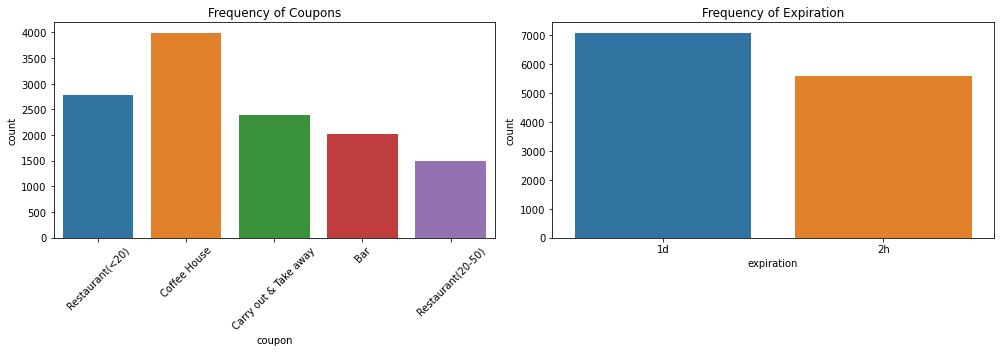

In [65]:
# Frequency + acceptance for coupon
if 'Y' in df.columns:
    coupon_summary = (
        df.groupby('coupon')
        .agg(frequency=('coupon', 'count'), acceptance_rate=('Y', 'mean'))
        .reset_index()
    )
    print("\nCoupon Summary (Frequency & Acceptance Rate):")
    print(coupon_summary, "\n")

    expiration_summary = (
        df.groupby('expiration')
        .agg(frequency=('expiration', 'count'), acceptance_rate=('Y', 'mean'))
        .reset_index()
    )
    print("Expiration Summary (Frequency & Acceptance Rate):")
    print(expiration_summary, "\n")

else:
    # fallback if Y does not exist
    print("Frequency counts per coupon:")
    print(df['coupon'].value_counts(), "\n")

    print("Frequency counts per expiration:")
    print(df['expiration'].value_counts(), "\n")


# Plot frequencies
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

sns.countplot(x='coupon', data=df, ax=axes[0])
axes[0].set_title('Frequency of Coupons')
axes[0].tick_params(axis='x', rotation=45)

sns.countplot(x='expiration', data=df, ax=axes[1])
axes[1].set_title('Frequency of Expiration')

plt.tight_layout()
plt.show()


Observations from the analysis above;
1.  Coupons:
* Coffee House is the most frequently offered coupon.
* Followed by Restaurant(<20)  and Carry out & Take away.
* Least frequent is Restaurant(20–50), suggesting high-priced offers are less common.

2.  Expiration:
* Most coupons have a 1-day expiration, making it more common and likely more convenient for users.
* Fewer coupons have a 2-hour expiration.

3. Acceptance rates:
* Highest acceptance coupons: Carry out & Take away (74%) and Restaurant(<20) (71%).
* Lowest acceptance coupon: Bar (41%).
4. Best expiration perid: 1-day (63%) which is better accepted than 2-hour (50%).

In summary:
* Most common coupon: Coffee House.
* Least common coupon: Restaurant(20–50).
* Most common expiration: 1-day.

**Insight**:  Longer expirations and affordable coupons are more frequently offered and more likely to be accepted.

#### 2.1 Demographics Analysis
Demographic analysis is done to help us  understand customer characteristics and behaviors, revealing patterns that influence preferences and acceptance rates. It enables targeted coupons, personalized offers and data-driven decisions by identifying which segments are most responsive and which need tailored strategies.

#### Distributions of gender, age, income, education, marital status

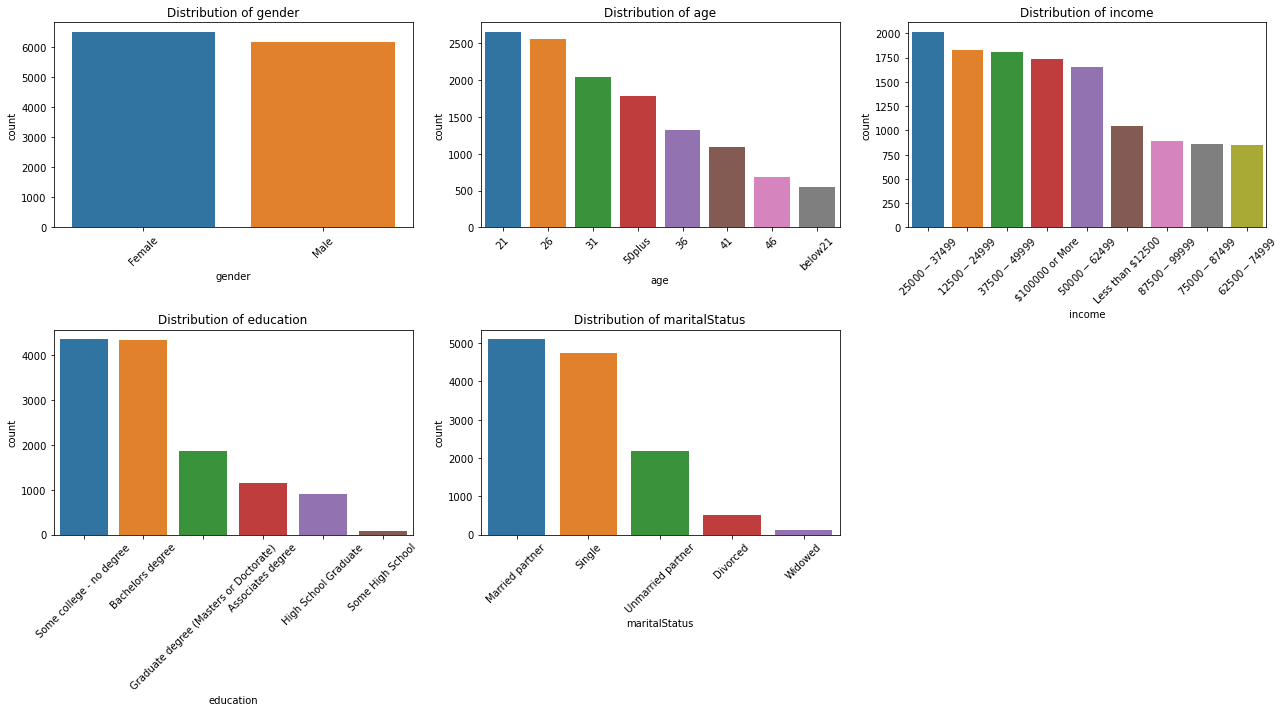

In [67]:
demograph_cols = ['gender', 'age', 'income', 'education', 'maritalStatus']

# Create subplots
fig, axes = plt.subplots(2, 3, figsize=(18, 10))  # adjust rows & cols as needed
axes = axes.flatten()  # flatten to 1D array for easy looping

for i, col in enumerate(demograph_cols):
    sns.countplot(x=col, data=df, order=df[col].value_counts().index, ax=axes[i])
    axes[i].set_title(f'Distribution of {col}')
    axes[i].tick_params(axis='x', rotation=45)

# Hide any unused axes
for j in range(len(demograph_cols), len(axes)):
    axes[j].set_visible(False)

plt.tight_layout()
plt.show()

### 3. Bivariate Exploration

#### 3.0 Target variable Bivariate Exploration
Here we'll explore:
-  The frequency counts of the combination of coupon and expiration
-  Whether some combinations very rare as this could cause imbalance problems

Frequency counts per (coupon + expiration) combination:
                  coupon expiration  count
0                    Bar         1d   1556
1                    Bar         2h    461
2  Carry out & Take away         1d   1456
3  Carry out & Take away         2h    937
4           Coffee House         1d   1769
5           Coffee House         2h   2227
6      Restaurant(20-50)         1d    956
7      Restaurant(20-50)         2h    536
8        Restaurant(<20)         1d   1354
9        Restaurant(<20)         2h   1432 



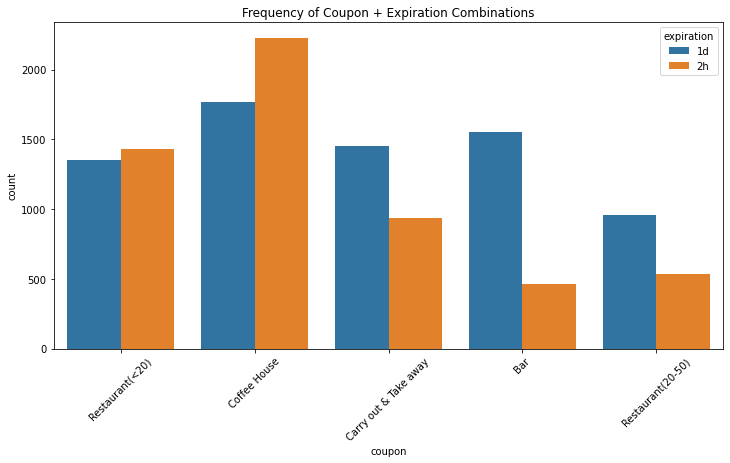

Acceptance rates by coupon + expiration:
                  coupon expiration         Y
0                    Bar         1d  0.411954
1                    Bar         2h  0.403471
2  Carry out & Take away         1d  0.781593
3  Carry out & Take away         2h  0.663821
4           Coffee House         1d  0.583946
5           Coffee House         2h  0.431971
6      Restaurant(20-50)         1d  0.520921
7      Restaurant(20-50)         2h  0.298507
8        Restaurant(<20)         1d  0.831610
9        Restaurant(<20)         2h  0.589385


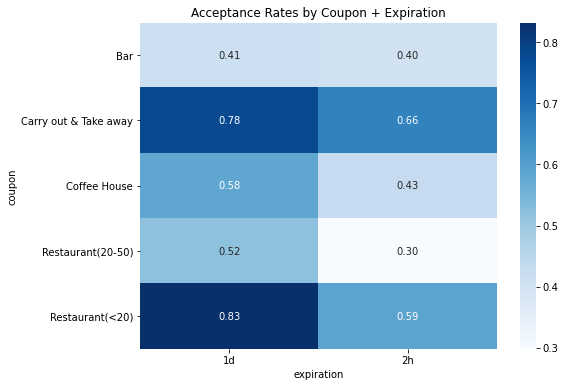

In [ ]:
# Frequency counts for coupon + expiration
print("Frequency counts per (coupon + expiration) combination:")
combo_counts = df.groupby(['coupon', 'expiration']).size().reset_index(name='count')
print(combo_counts, "\n")

# Checking for rare combinations (<1% of data)
total = len(df)
rare_combos = combo_counts[combo_counts['count'] / total < 0.01]
if not rare_combos.empty:
    print("Rare coupon+expiration combinations (<1% of data):")
    print(rare_combos)

# Bar plot for coupon + expiration
plt.figure(figsize=(12, 6))
sns.countplot(x='coupon', hue='expiration', data=df)
plt.title('Frequency of Coupon + Expiration Combinations')
plt.xticks(rotation=45)
plt.show()

# With Y acceptance rates
if 'Y' in df.columns:
    print("Acceptance rates by coupon + expiration:")
    acceptance_combo = df.groupby(['coupon', 'expiration'])['Y'].mean().reset_index()
    print(acceptance_combo)

    # heatmap of acceptance rates
    pivot = acceptance_combo.pivot(index='coupon', columns='expiration', values='Y')
    plt.figure(figsize=(8,6))
    sns.heatmap(pivot, annot=True, cmap='Blues', fmt=".2f")
    plt.title('Acceptance Rates by Coupon + Expiration')
    plt.show()


Observations from the analysis above:

1. Highest acceptance coupons:
     * Carry out & Take away (74%) and Restaurant(<20) (71%).
2. Lowest acceptance coupon: Bar (41%).
     * Best expiration: 1-day (63%) are better accepted than 2-hour (50%).
3. No combination is rare(<1% of data)

**Insight**: Affordable coupons and longer expiration are more likely to be accepted.

####  3.1 Demographics vs Coupon Preference

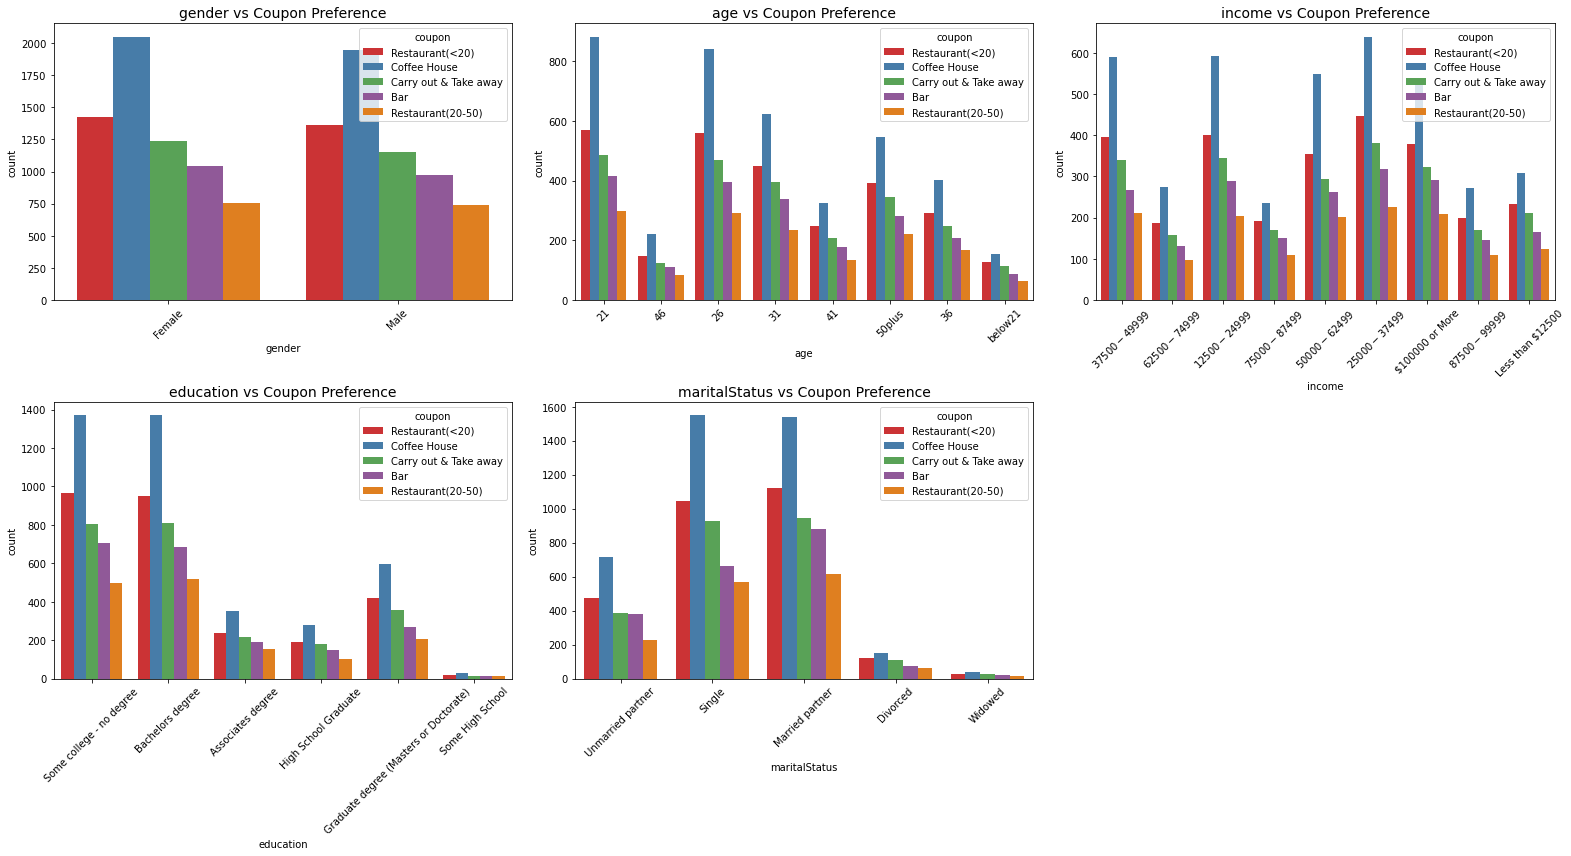

In [85]:

#  demographic columns 
demograph_cols = ['gender', 'age', 'income', 'education', 'maritalStatus']

# Plotting
fig, axes = plt.subplots(2, 3, figsize=(22, 12))
axes = axes.flatten()  

# Loop through each demographic column
for i, col in enumerate(demograph_cols):
    
    sns.countplot(
        x=col, 
        hue='coupon', 
        data=df, 
        ax=axes[i], 
        palette='Set1' 
    )
    axes[i].set_title(f'{col} vs Coupon Preference', fontsize=14)
    axes[i].tick_params(axis='x', rotation=45)

# Hide any unused subplot axes
for j in range(len(demograph_cols), len(axes)):
    axes[j].set_visible(False)


plt.tight_layout()
plt.show()

#### 3.2 Demographics vs Expiration Preference 

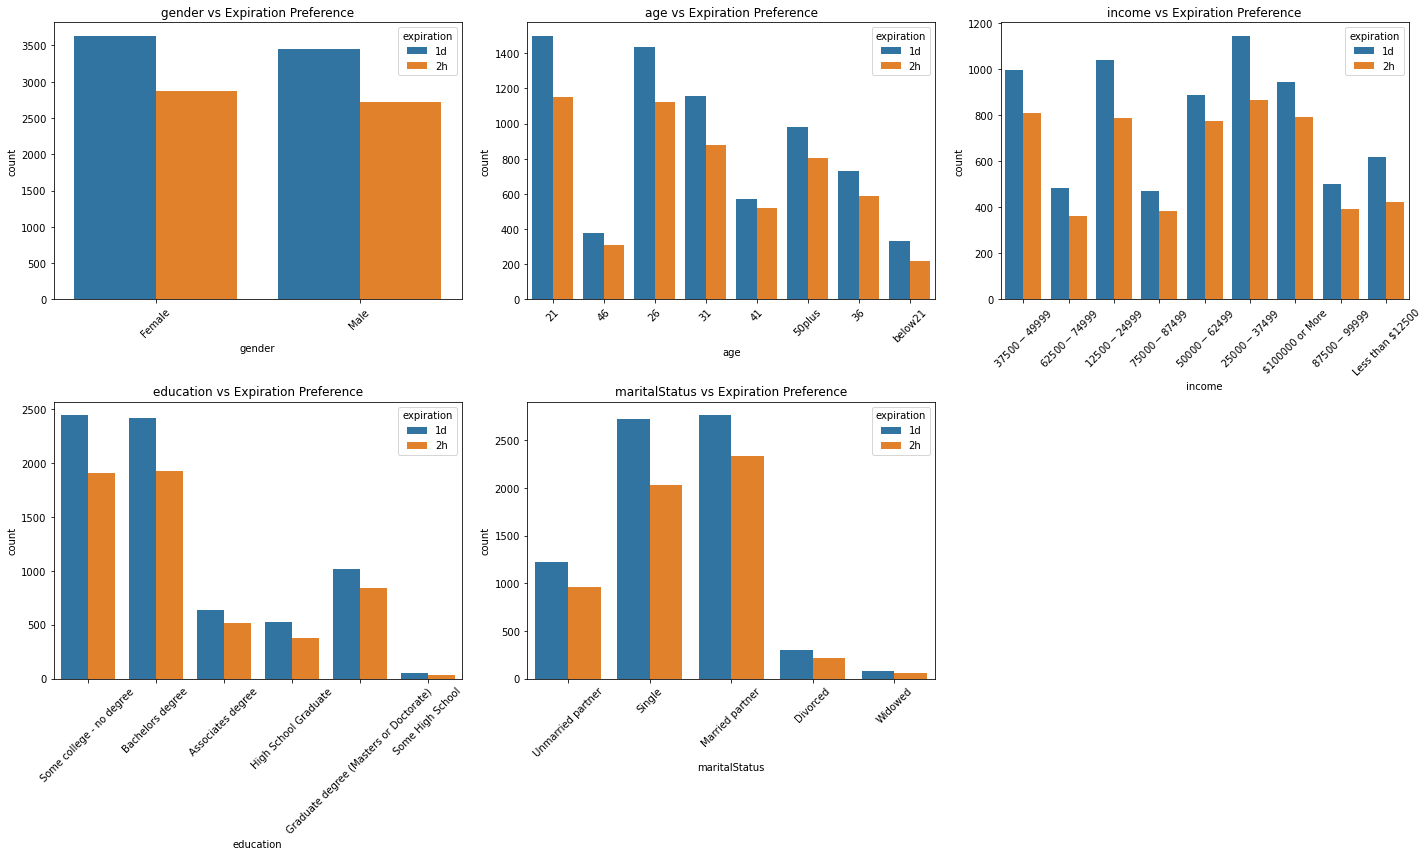

In [ ]:
# Plotting-barplot
fig, axes = plt.subplots(2, 3, figsize=(20, 12))
axes = axes.flatten()

for i, col in enumerate(demograph_cols):
    sns.countplot(x=col, hue='expiration', data=df, ax=axes[i])
    axes[i].set_title(f'{col} vs Expiration Preference')
    axes[i].tick_params(axis='x', rotation=45)

for j in range(len(demograph_cols), len(axes)):
    axes[j].set_visible(False)

plt.tight_layout()
plt.show()


#### 3.3 Demographics vs Acceptance Rate

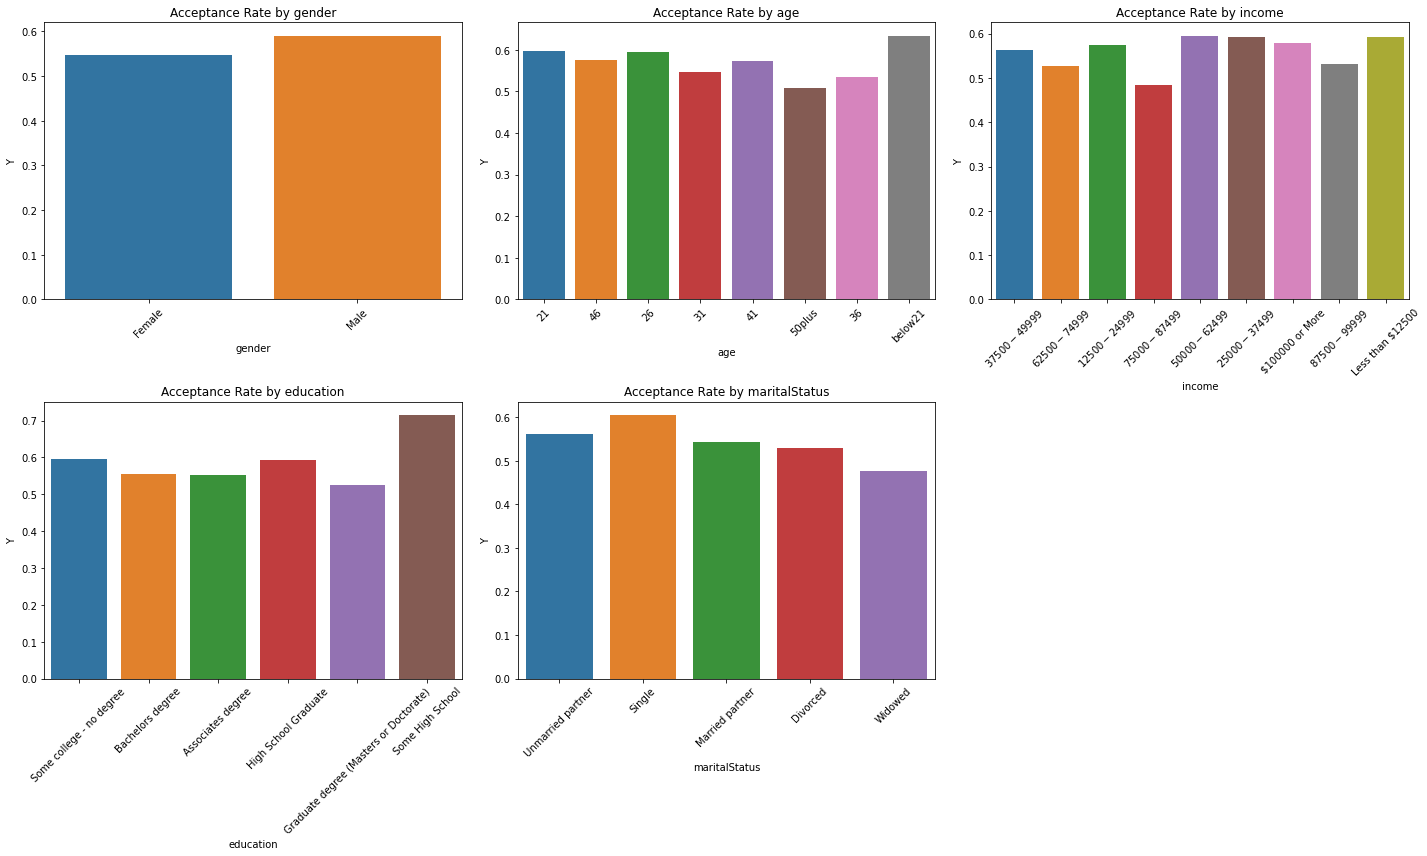

In [ ]:
# Plotting -Barplot
fig, axes = plt.subplots(2, 3, figsize=(20, 12))
axes = axes.flatten()

for i, col in enumerate(demograph_cols):
    sns.barplot(x=col, y='Y', data=df, estimator=np.mean, ci=None, ax=axes[i])
    axes[i].set_title(f'Acceptance Rate by {col}')
    axes[i].tick_params(axis='x', rotation=45)

for j in range(len(demograph_cols), len(axes)):
    axes[j].set_visible(False)

plt.tight_layout()
plt.show()


**Observations**
1. Distributions of Demographics
   - Gender, age, income, education, and marital status are well-represented across categories.
   - Younger age groups (21–31), middle-income brackets, and single/unmarried individuals make up a significant portion of the dataset.

2. Demographics vs Coupon Preference
   - Younger, single users tend to prefer lower-value or quick-service coupons like Carry out & Take away and Restaurant(<20).
   - Higher-income and older users lean slightly toward Coffee House coupons.
   - Gender differences in coupon preferences are small but noticeable.

3. Demographics vs Expiration Preference
   - Across all demographics, 1-day expiration is preferred over 2-hour.
   - Younger and middle-income users show a stronger preference for 1-day offers.
 
4.  Demographics vs Acceptance Rate (Y)
    - Higher acceptance rates are seen in younger, single, middle-income, and moderately educated groups.
    - Married, older, higher-income, and graduate-educated users tend to have lower acceptance rates.

**Insights**
- Focus coupons on young, single, middle-income, and moderately educated segments as they are the most responsive.
- Offer 1-day expiration coupons more often, especially to the most engaged groups.
- Use demographic clustering to build personalized recommendations & offers.
- Design premium or customized coupons to engage less-responsive segments (i.e higher-income, married, older users).